# Proyecto final
## Implementación en Python 
### José Alberto Moreno Guerra

In [1]:
%pylab inline
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import scipy.stats as st
import math
import random
from scipy.optimize import fmin
import seaborn as sb
from cycler import cycler
plt.style.use('classic')
#%matplotlib inline

# Choose the "true" parameters.
alpha_true = 0.141
om_true = 0.294
beta_true = 3.101
M_b_true = -19.05
delta_Mb = -0.070
#f_true = 0.534

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Realizamos la lectura de los datos
data_f=np.loadtxt('jla_lcparams.txt',delimiter = '\t',skiprows=0,usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
jla_mu=np.loadtxt('jla_mub.txt',delimiter = '\t',skiprows=0,usecols=[0,1])
z = jla_mu[:,0]
mud = jla_mu[:,1]
n=np.size(data_f[:,0])


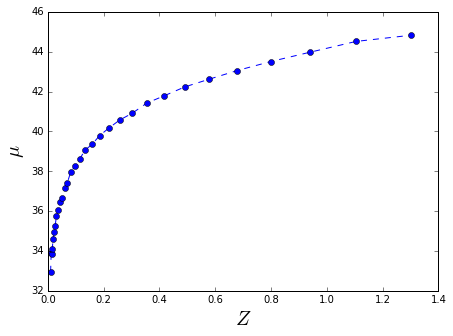

In [3]:
plt.figure(figsize=(7,5))
plt.plot(z,mud,'b--o')
plt.xlabel('$Z$',fontsize = 20)
plt.ylabel('$\mu$',fontsize = 20)
plt.show()

In [4]:
def eta(a,om):
    s3=(1.-om)/om
    s2=s3**(2./3)
    s=s3**(1./3)
    coef=[0.1540,0.4304,0.19097,0.066941]
    return 2.*np.sqrt(s3+1.)*((1./a**4)-coef[0]*s*(1./a**3)+coef[1]*s2*(1./a**2)+coef[2]*s3*(1./a)+coef[3]*(s**4))**(-1./8)
# Definición del likelihood

In [5]:
def sup(om,z):
    om = om
    c=299792.0 # velocidad de la luz en km/s
    a=1./(1+z)
    D =(c/70.0)*(1./a)*(eta(1.,om)-eta(a,om))
    y = 25.0-(5.*np.log10(70.0/100.0))+5.*np.log10(D)
    return y

In [6]:
# Abrimos el arch. que contiene los datos 
f1=np.loadtxt('jla_mub_covmatrix.dat',delimiter = '\t',skiprows=0,usecols=[0,0]) 
covmatrix=f1[:,0]
n=np.size(covmatrix) # Contabilizamos el número de datos que tenemos

In [7]:
def cmz(v_data):
    covmat = []
    N = int(math.sqrt(len(v_data)))
    for i in range(N):
        row=[]
        for j in range(N):
            row.append(v_data[(N*i)+j])
        covmat.append(row)
    return covmat

In [8]:
cov=np.ones((31, 31))
m=0
for i in range(31):
    for j in range(31):
        cov[i][j]=covmatrix[m]
        m=m+1
var=np.diag(cov)

In [9]:
dt_1 = np.loadtxt('jla_v0a_covmatrix.dat')
dt_2 = np.loadtxt('jla_v0b_covmatrix.dat')
dt_3 = np.loadtxt('jla_v0_covmatrix.dat')
dt_4 = np.loadtxt('jla_vab_covmatrix.dat')
dt_5 = np.loadtxt('jla_va_covmatrix.dat')
dt_6 = np.loadtxt('jla_vb_covmatrix.dat')

In [10]:
mag_stretch_covmat_file = np.array(cmz(dt_1))
mag_colour_covmat_file = np.array(cmz(dt_2))
mag_covmat_file = np.array(cmz(dt_3))
stretch_colour_covmat_file = np.array(cmz(dt_4))
stretch_covmat_file = np.array(cmz(dt_5))
colour_covmat_file = np.array(cmz(dt_6))

In [11]:
# Matriz de covarianza:
cov = mag_covmat_file + stretch_covmat_file + colour_covmat_file + mag_stretch_covmat_file + mag_colour_covmat_file + stretch_colour_covmat_file

In [12]:
cov=np.reshape(cov, (740,740))
var2=np.diag(cov)
print(np.size(var2))

740


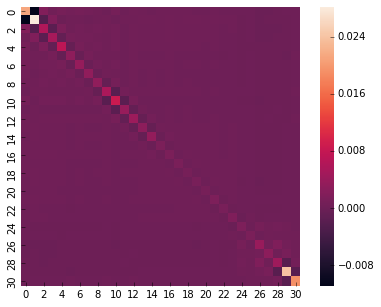

In [13]:
plt.figure(figsize=(7,5))
mcov=np.reshape(covmatrix, (31,31))
plt.imshow(mcov, cmap='YlGnBu')
sb.heatmap(mcov)
plt.show()

In [14]:
def mu(mb,M_b,delta_Mb,alpha,beta,c,x_1):
    mu = mb-((M_b+delta_Mb)- alpha*x_1 + beta+c)
    return mu 

In [15]:
global zcmb, mb, color, x_1
zcmb = data_f[:,0]
mb = data_f[:,2]
color = data_f[:,7]
x_1 = data_f[:,4]

In [16]:
def lnlike(theta, z, y, var2):
    M_b, delta_Mb, alpha, beta = theta
    y = sup(om_true, z)
    model = mu(mb,M_b,delta_Mb,alpha,beta,color,x_1)
    inv_sigma2 = 1.0/(var2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [17]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
bnds= ((-20.0,-18.0),(-0.05,-0.2),(4.0,5.0),(-0.08,-0.05))
result= op.minimize(nll,[-19, -0.065, 0.125, 4.5], args=(zcmb, sup(om_true,zcmb), var2), bounds=bnds)
M_b, d_Mb, alpha, beta = result["x"]

In [18]:
print(M_b, d_Mb, alpha, beta)

(-19.0, -0.065000000000000002, 0.125, 4.5)


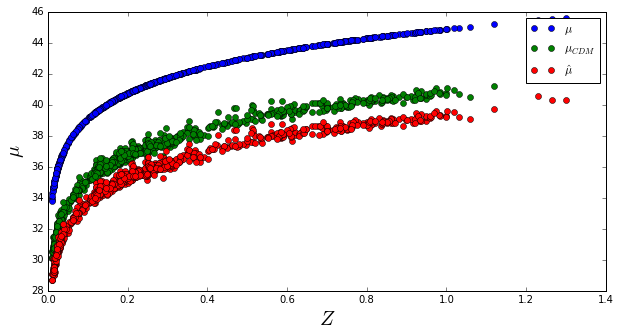

In [19]:
#plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.plot(zcmb,sup(om_true,zcmb),'o',label='$\mu$')
y1 = mu(mb,M_b_true,delta_Mb,alpha_true,beta_true,color,x_1)
plt.plot(zcmb,y1,'o',label='$\mu_{CDM}$')
y2 = mu(mb,M_b,d_Mb,alpha,beta,color,x_1)
plt.plot(zcmb,y2,'o', label='$\hat{\mu}$')
plt.xlabel('$Z$',fontsize = 20)
plt.ylabel('$\mu$',fontsize = 20)
#plt.axis([0.0, 1.3, 0.0, 50.0]) 
plt.legend()
plt.show()

In [20]:
def lnprior(theta):
    M_b, delta_Mb, alpha, beta = theta
    if -20.0 < M_b < 550.0 and -0.5 < delta_Mb < 0.05 and 0.001 < alpha < 10.0 and 2.0 < beta < 6.0:
        return 0.0
    return np.inf

In [21]:
def lnprob(theta, z, y, var):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, z, y, var)

In [22]:
ndim, nwalkers = 4, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [23]:
mud = sup(om_true,data_f[:,0])

In [24]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(zcmb, mud, var2))

In [25]:
sampler.run_mcmc(pos, 500)
print()

()


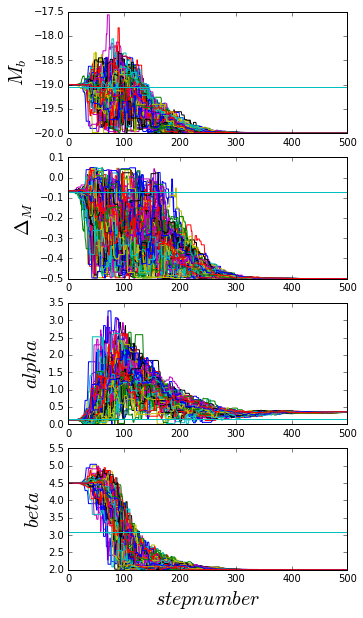

In [26]:
x1 = np.linspace(0.0, 500, 500)
plt.figure(figsize=(5,10))
for i in range(100):
    plt.subplot(4, 1, 1)
    plt.plot(x1, sampler.chain[i,:,0], '-')
    plt.plot(x1, M_b_true*np.ones(500), '-')
    plt.ylabel('$M_{b}$',fontsize = 20)

    plt.subplot(4, 1, 2)
    plt.plot(x1, sampler.chain[i,:,1], '-')
    plt.plot(x1, delta_Mb*np.ones(500), '-')
    plt.ylabel('$\Delta_{M}$',fontsize = 20)
    
    plt.subplot(4, 1, 3)
    plt.plot(x1, sampler.chain[i,:,2], '-')
    plt.plot(x1, alpha_true*np.ones(500), '-')
    plt.ylabel('$alpha$',fontsize = 20)
    
    plt.subplot(4, 1, 4)
    plt.plot(x1, sampler.chain[i,:,3], '-')
    plt.plot(x1, beta_true*np.ones(500), '-')
    plt.ylabel('$beta$',fontsize = 20)
    plt.xlabel('$stepnumber$',fontsize = 20)
plt.show()

In [27]:
samples = sampler.chain[:, 400:, :].reshape((-1, ndim))

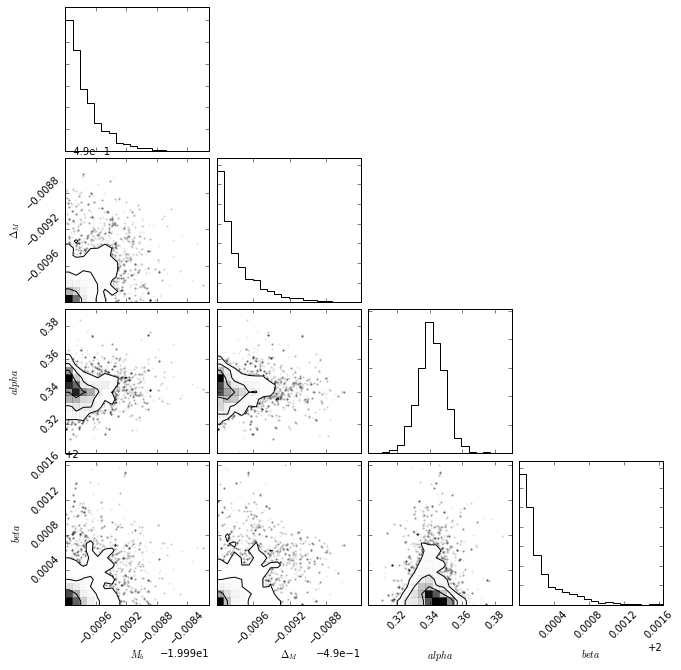

In [28]:
import corner
fig = corner.corner(samples, labels=["$M_{b}$", "$\Delta_{M}$", "$alpha$", "$beta$"],
                      truths=[M_b_true, delta_Mb, alpha_true, beta_true])
fig.savefig("1401.png")

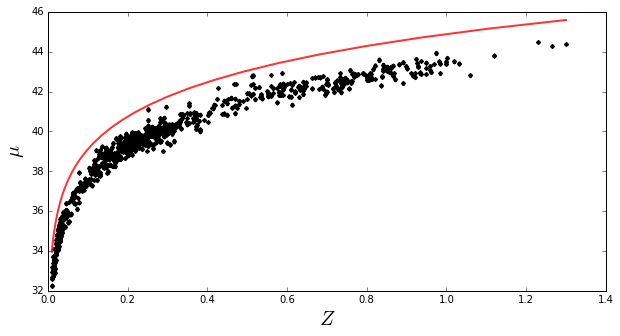

In [29]:
plt.figure(figsize=(10,5))
xl = np.array([0, 10])
for M_b, delta_Mb, alpha, beta in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(zcmb, mu(mb,M_b, delta_Mb, alpha, beta,color,x_1), 'k.', alpha=0.1)
plt.plot(z, sup(om_true,z), color="r", lw=2, alpha=0.8)
plt.xlabel('$Z$',fontsize = 20)
plt.ylabel('$\mu$',fontsize = 20)
plt.show()